# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [18]:
import os
import torch
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [19]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [20]:
start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 100

### Define QoI function

In [21]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

## Baseline samples before optimization from the two models

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.410633,9.711964,1.359564,0.120533,999.519897
1,1,0,2.0,0.410633,9.711964,1.847987,0.284386,998.867554
2,2,0,3.0,0.410633,9.711964,2.511093,0.507069,997.981445
3,3,0,4.0,0.410633,9.711964,3.410685,0.809592,996.779480
4,4,0,5.0,0.410633,9.711964,4.629878,1.220374,995.149658
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.354493,11.943808,381.263916,498.130188,121.605545
3896,35,99,36.0,0.354493,11.943808,365.068756,529.383118,106.547462
3897,36,99,37.0,0.354493,11.943808,347.857422,559.233398,93.909691
3898,37,99,38.0,0.354493,11.943808,330.097504,587.617004,83.285736


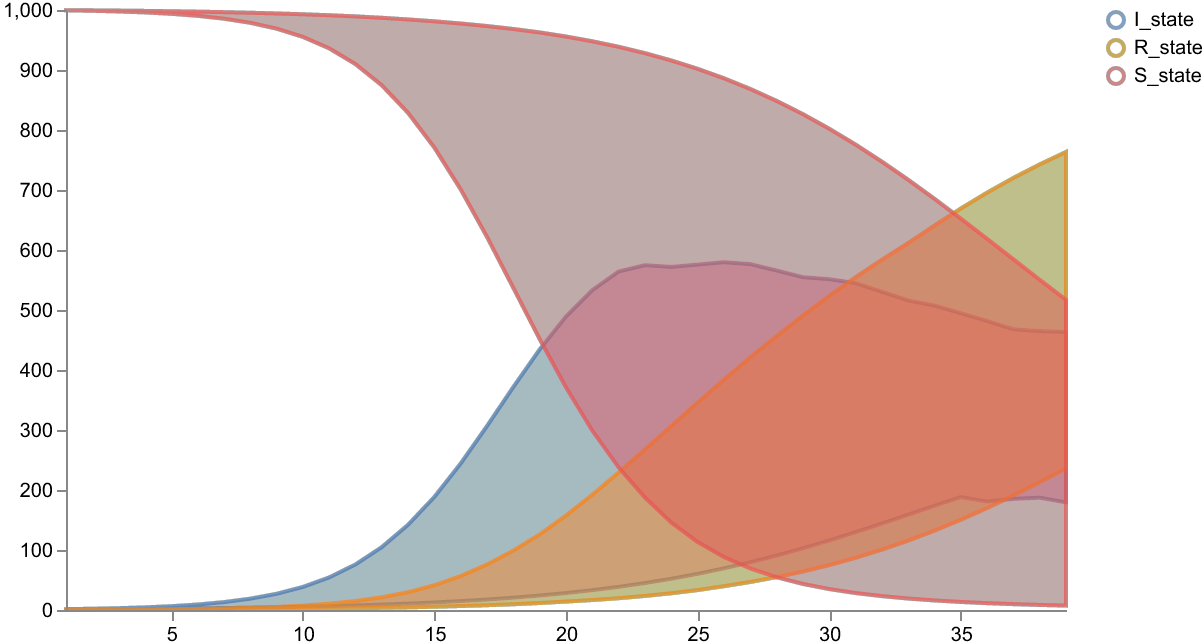

In [22]:
sample_results1 = pyciemss.sample(
    model_opt1, end_time, logging_step_size, num_samples, start_time=start_time
)
display(sample_results1["data"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.659175,0.740094,0.452672,0.103997,0.047875,8.674343,0.000000,36.419823,0.408357,14.747707,3.518279,19339986.0,14.747707,36.419823,0.408357,0.000000
1,1,0,2.0,0.659175,0.740094,0.452672,0.103997,0.047875,8.674343,0.003910,38.229546,1.020954,17.176783,9.577651,19339976.0,17.176783,38.229546,1.020954,0.003910
2,2,0,3.0,0.659175,0.740094,0.452672,0.103997,0.047875,8.674343,0.013686,41.384571,1.625384,18.958714,16.738901,19339964.0,18.958714,41.384571,1.625384,0.013686
3,3,0,4.0,0.659175,0.740094,0.452672,0.103997,0.047875,8.674343,0.029249,45.069626,2.192815,20.722771,24.737993,19339950.0,20.722771,45.069626,2.192815,0.029249
4,4,0,5.0,0.659175,0.740094,0.452672,0.103997,0.047875,8.674343,0.050245,49.138969,2.729805,22.609550,33.560631,19339934.0,22.609550,49.138969,2.729805,0.050245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.411714,0.780995,0.286882,0.063476,0.036897,4.189610,7.451873,6687.610352,176.891617,3630.273682,5784.188965,19323752.0,3630.273682,6687.610352,176.891617,7.451873
3896,35,99,36.0,0.411714,0.780995,0.286882,0.063476,0.036897,4.189610,8.757215,7848.552734,207.620743,4260.717773,6793.612793,19320920.0,4260.717773,7848.552734,207.620743,8.757215
3897,36,99,37.0,0.411714,0.780995,0.286882,0.063476,0.036897,4.189610,10.289318,9210.732422,243.684448,5000.534668,7978.338379,19317596.0,5000.534668,9210.732422,243.684448,10.289318
3898,37,99,38.0,0.411714,0.780995,0.286882,0.063476,0.036897,4.189610,12.087547,10808.919922,286.007507,5868.656738,9368.778320,19313696.0,5868.656738,10808.919922,286.007507,12.087547


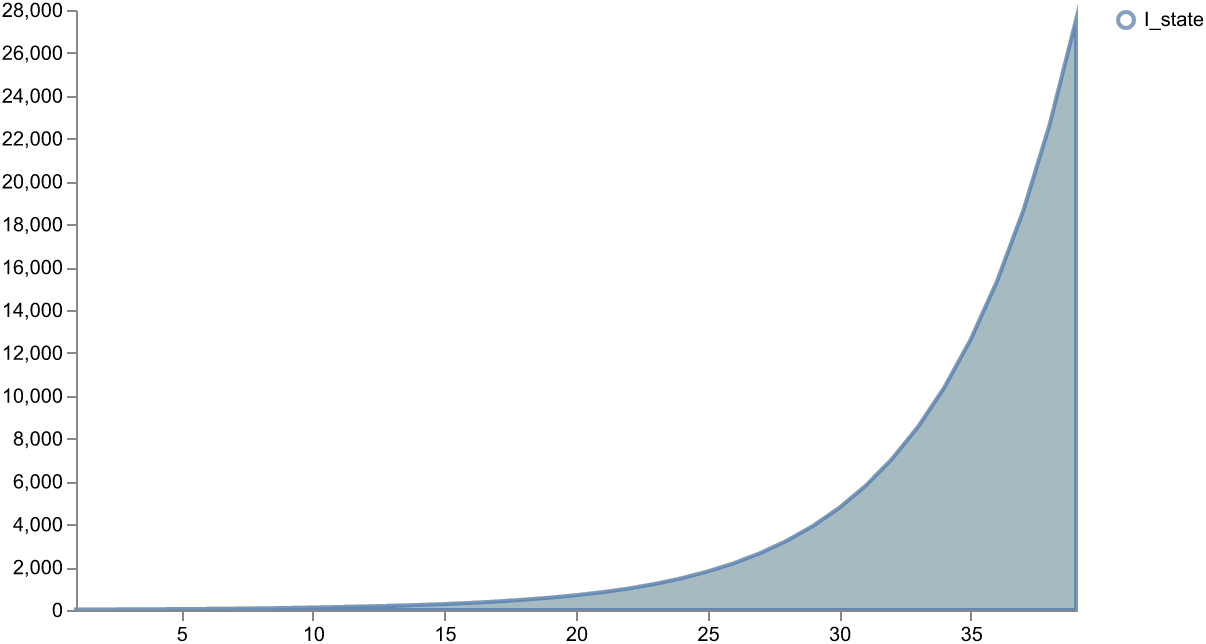

In [30]:
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="euler",
)
display(sample_results2["data"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [15]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=int(1e2),
    maxiter=0,
    maxfeval=20,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

#### Sample using optimal policy as intervention

In [24]:
result1 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="euler",
)
display(result1["data"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

{1.0: {'p_cbeta': tensor([0.2237])}}


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.314054,19.060932,1.261276,0.052463,999.686279
1,1,0,2.0,0.314054,19.060932,1.476883,0.118634,999.404480
2,2,0,3.0,0.314054,19.060932,1.729253,0.196116,999.074646
3,3,0,4.0,0.314054,19.060932,2.024620,0.286839,998.688538
4,4,0,5.0,0.314054,19.060932,2.370264,0.393057,998.236694
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.390894,9.445127,48.182121,46.284496,906.533569
3896,35,99,36.0,0.390894,9.445127,52.842022,51.385765,896.772400
3897,36,99,37.0,0.390894,9.445127,57.837330,56.980400,886.182434
3898,37,99,38.0,0.390894,9.445127,63.167980,63.103909,874.728271


## Optimize interface for optimizing start time

In [32]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 1.
bounds_interventions = [[0.5], [39.5]]
intervention_value = [0.15]
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor(intervention_value),
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=10,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)











6it [00:46,  7.75s/it]

Optimal policy: tensor([4.], dtype=torch.float64)
{'policy': tensor([4.], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -4.0
                          x: [ 4.000e+00]
                        nit: 1
      minimization_failures: 2
                       nfev: 4
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -4.0
                                   x: [ 4.000e+00]
                                nfev: 2
                               maxcv: 0.0}


In [33]:
result2 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
)
display(result2["data"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.349256,12.813910,1.270867,0.078040,999.651123
1,1,0,2.0,0.349256,12.813910,1.614947,0.177219,999.207886
2,2,0,3.0,0.349256,12.813910,2.051936,0.303250,998.644836
3,3,0,4.0,0.349256,12.813910,2.606766,0.463383,997.929871
4,4,0,5.0,0.349256,12.813910,2.232644,0.474755,998.292603
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.313551,17.372927,29.385365,17.954084,953.660400
3896,35,99,36.0,0.313551,17.372927,31.893269,19.645531,949.461060
3897,36,99,37.0,0.313551,17.372927,34.595139,21.481333,944.923401
3898,37,99,38.0,0.313551,17.372927,37.502380,23.472658,940.024841


## Optimize for start times of multiple interventions

In [7]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta", "p_tr"]
initial_guess_interventions = [5., 5.]
bounds_interventions = [[5., 5.], [39., 39.]]
intervention_value = [0.15, 15]
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor(intervention_value),
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=10,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result3["policy"])
print(opt_result3)


22it [04:42, 12.85s/it]

Optimal policy: tensor([33.4822, 33.7300], dtype=torch.float64)
{'policy': tensor([33.4822, 33.7300], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -67.21213438451318
                          x: [ 3.348e+01  3.373e+01]
                        nit: 1
      minimization_failures: 2
                       nfev: 20
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -67.21213438451318
                                   x: [ 3.348e+01  3.373e+01]
                                nfev: 10
                               maxcv: 0.0}


In [8]:
static_parameter_interventions(opt_result3["policy"])

{33.4822: {'p_cbeta': tensor(0.1500)}, 33.73: {'p_tr': tensor(15.)}}

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.266023,14.559804,1.197075,0.068682,999.734253
1,1,0,2.0,0.266023,14.559804,1.432904,0.150900,999.416199
2,2,0,3.0,0.266023,14.559804,1.715071,0.249315,999.035645
3,3,0,4.0,0.266023,14.559804,2.052629,0.367110,998.580322
4,4,0,5.0,0.266023,14.559804,2.456376,0.508089,998.035583
...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,15.000000,195.047150,445.654022,360.299072
9896,95,99,96.0,0.150000,15.000000,192.574768,458.657166,349.768311
9897,96,99,97.0,0.150000,15.000000,189.829834,471.495483,339.674927
9898,97,99,98.0,0.150000,15.000000,186.836914,484.150818,330.012512


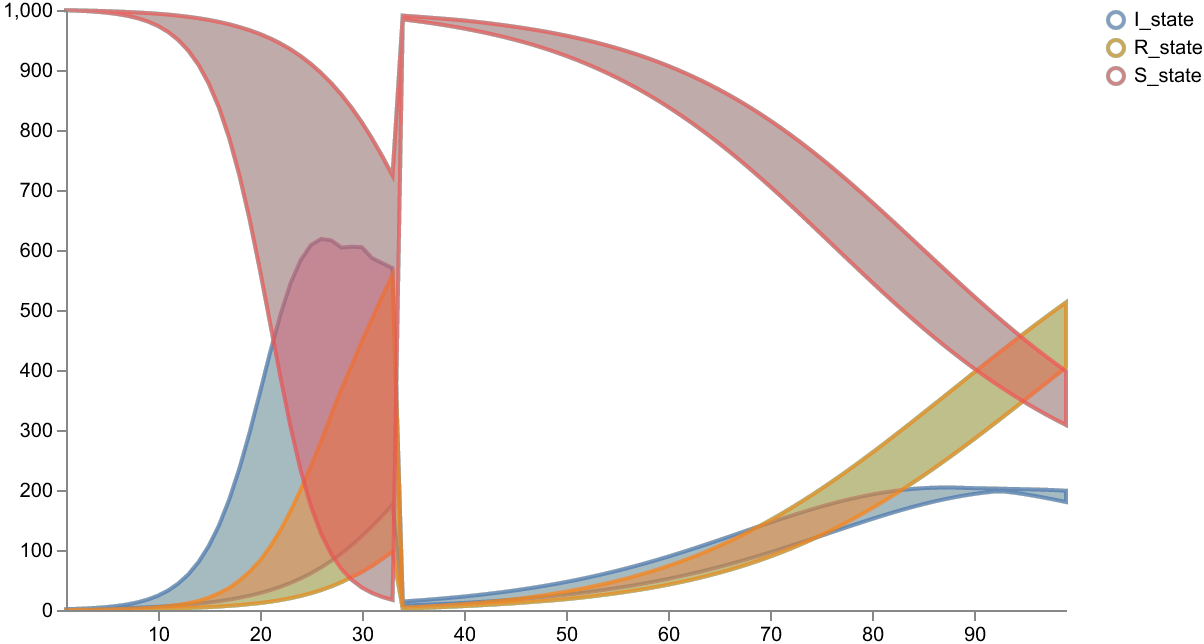

In [17]:
end_time = 100.
result3 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
    solver_method="euler",
)
display(result3["data"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)